# Preamble

Theodore Barnhart | tbarnhart@usgs.gov | theodore.barnhart@colorado.edu | April 6, 2019

This notebook explores global parameter sensivitivty using the dela-moment method (Plischke et al., 2013).

This is done via two analyses:

**Analysis 1:**
SA is run on outputs with only optimized rooting depth (combo == 6)

**Analysis 2:**
SA is run on outputs with all rooting depths to assess the importance of plant available water storage (PAWS).

In [1]:
import pandas as pd
from SALib.analyze import delta
import matplotlib.pyplot as plt

## Load Data

In [2]:
# load data
site = 'Nr1'
exname = 'smex8_sen'
method = '8'
period = 'melt'
Nr1 = pd.read_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df') # load the first experiment

site = 'p301'
exname = 'smex8_sen'
method = '8'
period = 'melt'
P301 = pd.read_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')

In [3]:
# clean the data to remove scenarios where ET is greater than snowmelt
Nr1 = Nr1.loc[Nr1.ablRR_ET>0]
P301 = P301.loc[P301.ablRR_ET>0]

In [4]:
def plotSI(Si, problem, figsize=(6,4)):
    figsize = (6,4)
    xax = np.arange(1,len(Si['delta'])+1)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.errorbar(xax,Si['delta'],yerr=Si['delta_conf'],fmt = '.');
    plt.xticks(ticks=xax, labels=problem['names'], fontsize = 14);
    ax.set_xlabel('Parameter', fontsize = 16);
    ax.set_ylabel('$\delta$', fontsize= 16);
    return ax

# Analysis 1

In [5]:
# define problem
problem = {
    'num_vars': 3,
    'names': ['SMR', 'SMT', 'PeakSWE'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

In [6]:
# define problem
problem = {
    'num_vars': 2,
    'names': ['SMR', 'SMT'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

In [7]:
#Nr1X = Nr1.loc[Nr1.combo == 6,['SMR','TpeakSWE','PeakSWE']].copy().values # get input parameters
Nr1X = Nr1.loc[Nr1.combo == 6,['SMR','TpeakSWE']].copy().values # get input parameters
#Nr1Y = Nr1.loc[Nr1.combo == 6,'ablRR_ET'].copy().values # get output
Nr1Y = Nr1.loc[Nr1.combo == 6,'wb'].copy().values # get output

#P301X = P301.loc[P301.combo == 6,['SMR','TpeakSWE','PeakSWE']].copy().values # get input parameters
P301X = P301.loc[P301.combo == 6,['SMR','TpeakSWE']].copy().values # get input parameters
#P301Y = P301.loc[P301.combo == 6,'ablRR_ET'].copy().values # get output
P301Y = P301.loc[P301.combo == 6,'wb'].copy().values # get output

In [8]:
# compute the delta method sensitivity analysis
Nr1Si = delta.analyze(problem, Nr1X, Nr1Y, print_to_console=False, num_resamples=50)
P301Si = delta.analyze(problem, P301X, P301Y, print_to_console=False, num_resamples=50)

# Analysis 2

In [9]:
problem2 = {
    'num_vars': 4,
    'names': ['SMR', 'SMT', 'PeakSWE','RD'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

In [10]:
problem2 = {
    'num_vars': 3,
    'names': ['SMR', 'SMT','RD'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

In [11]:
#Nr1X = Nr1[['SMR','TpeakSWE','PeakSWE','rd']].copy().values # get input parameters
Nr1X = Nr1[['SMR','TpeakSWE','rd']].copy().values # get input parameters
#Nr1Y = Nr1['ablRR_ET'].copy().values # get output
Nr1Y = Nr1['wb'].copy().values # get output

#P301X = P301[['SMR','TpeakSWE','PeakSWE','rd']].copy().values # get input parameters
P301X = P301[['SMR','TpeakSWE','rd']].copy().values # get input parameters
#P301Y = P301['ablRR_ET'].copy().values # get output
P301Y = P301['wb'].copy().values # get output

In [12]:
# compute the delta method sensitivity analysis
Nr1Siall = delta.analyze(problem2, Nr1X, Nr1Y, print_to_console=False, num_resamples=50)
P301Siall = delta.analyze(problem2, P301X, P301Y, print_to_console=False, num_resamples=50)

# Collate data into dataframe

In [13]:
dat = pd.DataFrame()
dat['value'] = Nr1Si['delta']
dat['error'] = Nr1Si['delta_conf']
dat['parameter'] = problem['names']
dat['site'] = 'Nr1'
dat['analysis'] = 'Optimal PAWS'

tmp = pd.DataFrame()
tmp['value'] = P301Si['delta']
tmp['error'] = P301Si['delta_conf']
tmp['parameter'] = problem['names']
tmp['site'] = 'P301'
tmp['analysis'] = 'Optimal PAWS'

dat = pd.concat([dat,tmp])

tmp = pd.DataFrame()
tmp['value'] = P301Siall['delta']
tmp['error'] = P301Siall['delta_conf']
tmp['parameter'] = problem2['names']
tmp['site'] = 'P301'
tmp['analysis'] = 'All PAWS'

dat = pd.concat([dat, tmp])

tmp = pd.DataFrame()
tmp['value'] = Nr1Siall['delta']
tmp['error'] = Nr1Siall['delta_conf']
tmp['parameter'] = problem2['names']
tmp['site'] = 'Nr1'
tmp['analysis'] = 'All PAWS'

dat = pd.concat([dat, tmp])

dat.reset_index(inplace=True)
del dat['index']

In [14]:
def param2num(param):
    if param == 'SMR':
        return 1
    if param == 'SMT':
        return 2
    if param == 'PeakSWE':
        return 0
    if param == 'RD':
        return 3

In [15]:
dat['paramNum'] = dat.parameter.map(param2num)

In [16]:
#dat.to_pickle('./data/smex8_SA_delta.pcl')

# Plotting!

([<matplotlib.axis.XTick at 0x126f05d30>,
 <a list of 3 Text xticklabel objects>)

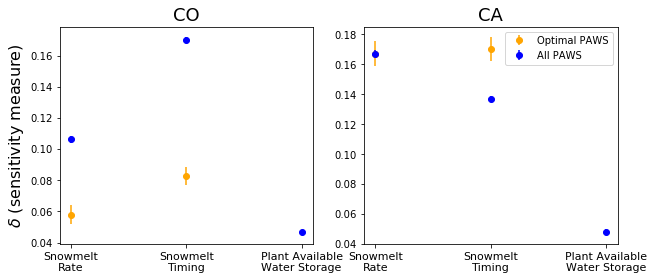

In [17]:
#xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Snowmelt\nAmount','Plant Available\nWater Storage']
xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Plant Available\nWater Storage']
xticks = np.arange(1,len(xlabels)+1)

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
plt.title('CO', fontsize = 18)

site = 'Nr1'

tmp = dat.loc[(dat.site==site) & (dat.analysis == 'Optimal PAWS')]
plt.errorbar(tmp['paramNum'], tmp['value'], yerr=tmp['error'], fmt = 'o', c='orange',label = 'Optimal PAWS')

tmp = dat.loc[(dat.site==site) & (dat.analysis == 'All PAWS')]
plt.errorbar(tmp['paramNum'], tmp['value'], yerr=tmp['error'], fmt = 'o', c='blue',label = 'All PAWS')

plt.xticks(ticks=xticks,labels=xlabels, fontsize = 11)
plt.ylabel('$\delta$ (sensitivity measure)', fontsize = 16)

ax2 = fig.add_subplot(122)
plt.title('CA', fontsize = 18)

site = 'P301'

tmp = dat.loc[(dat.site==site) & (dat.analysis == 'Optimal PAWS')]
plt.errorbar(tmp['paramNum'], tmp['value'], yerr=tmp['error'], fmt = 'o', c='orange',label = 'Optimal PAWS')

tmp = dat.loc[(dat.site==site) & (dat.analysis == 'All PAWS')]
plt.errorbar(tmp['paramNum'], tmp['value'], yerr=tmp['error'], fmt = 'o', c='blue',label = 'All PAWS')

plt.legend()

plt.xticks(ticks=xticks,labels=xlabels, fontsize = 11)